In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D,  GRU
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
X_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/X_test.npy")
y_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/y_test.npy")
person_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/person_train_valid.npy")
X_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/X_train_valid.npy")
y_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/y_train_valid.npy")
person_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/person_test.npy")


Mounted at /content/drive


In [ ]:
def random_flip(X):
    flip_axis = np.random.choice([-1, 1], size=(X.shape[0], X.shape[1], 1))
    return X * flip_axis

def time_warp(X, warp_factor=0.2):
    warp_offsets = np.random.uniform(-warp_factor, warp_factor, size=(X.shape[0], X.shape[1], 1))
    time_indices = np.arange(X.shape[2])
    warped_indices = np.clip(time_indices + warp_offsets * time_indices, 0, X.shape[2]-1).astype(int)
    return X[:, :, warped_indices]

def random_shift(X, shift_factor=0.1):
    shift_amount = np.random.uniform(-shift_factor * X.shape[2], shift_factor * X.shape[2], size=(X.shape[0], X.shape[1], 1))
    return np.roll(X, shift_amount, axis=2)

def random_scale(X, scale_factor=0.1):
    scale_factors = np.random.uniform(1 - scale_factor, 1 + scale_factor, size=(X.shape[0], X.shape[1], 1))
    return X * scale_factors


In [ ]:
def train_data_prep(X,y,sub_sample,average,noise, time = 800):


    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,:time]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        X_subsample = random_flip(X_subsample)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X, time = 800):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,:time]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X




In [ ]:
def loadrnndata(sub_sample = 2, average = 2, noise = True, subidx = None, time = 800):

    X_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/X_test.npy")
    y_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/y_test.npy")
    person_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/person_train_valid.npy")
    X_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/X_train_valid.npy")
    y_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/y_train_valid.npy")
    person_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/person_test.npy")


    # adjust labels
    y_train_valid -= 769
    y_test -= 769

    # Preprocess data
    X_train_valid_prep, y_train_valid_prep = train_data_prep(X_train_valid, y_train_valid, sub_sample = sub_sample, average = average, noise = noise, time = time)
    X_test_prep = test_data_prep(X_test)
    ## Random splitting and reshaping the data

    # Split into train and validation
    # First generating the training and validation indices using random splitting, 80/20 split for training and validation
    if subidx is not None:
      ind = np.where(person_train_valid == subidx)[0]
      ind_valid = np.random.choice(len(ind), int(len(ind) * 0.2), replace=False)
      ind_train = np.array(list(set(range(len(person_train_valid))).difference(set(ind[ind_valid]))))
    else:
      ind_valid = np.random.choice(8460, 1000, replace=False)
      ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
    (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]


    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test, 4)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    print('Shape of training set after dimension reshaping:',x_train.shape)
    print('Shape of validation set after dimension reshaping:',x_valid.shape)
    print('Shape of test set after dimension reshaping:',x_test.shape)

    return x_train, x_valid, x_test, y_train, y_valid, y_test

# Model Construction

In [ ]:
def lstmmodel(filters_list, kernel_size, pool_size, activation, dropout_rate, recurrent_dropout, time = 800):
    model = Sequential()

    for i in range(len(filters_list)):
        # Convolutional block
        print(filters_list[i])
        model.add(Conv2D(filters=filters_list[i], kernel_size = kernel_size, padding='same', activation=activation, input_shape=(int(time/2), 1, 22)))
        model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # FC+LSTM layers
    model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    model.add(Dense((40))) # FC layer
    model.add(Reshape((40,1))) # Reshape so compatible with lstm
    model.add(LSTM(units = 10, dropout=0.4, recurrent_dropout=recurrent_dropout, input_shape=(40,1), return_sequences=False))

    # Output layer with Softmax activation
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))

    # Printing the model summary
    model.summary()

    return model


In [ ]:

def grumodel(filters_list, kernel_size, pool_size, activation, dropout_rate, recurrent_dropout, time = 800):
    model = Sequential()

    for i in range(len(filters_list)):
        # Convolutional block
        model.add(Conv2D(filters=filters_list[i], kernel_size = kernel_size, padding='same', activation=activation, input_shape=(int(time/2), 1, 22)))
        model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # FC+GRU
    model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    model.add(Dense((40))) # FC layer
    model.add(Reshape((40,1))) # Reshape so compatible with GRU
    model.add(GRU(units = 20, dropout=0.4, recurrent_dropout=recurrent_dropout, input_shape=(40,1)))

    # Output layer with Softmax activation
    # model.add(Flatten())
    model.add(Dense(4, activation='softmax'))

    # Printing the model summary
    model.summary()

    return model

In [ ]:
filters_list = [25, 50, 100]
kernel_size = (8,8)
pool_size = (3,1)
activation = 'elu'
dropout_rate = 0.5
recurrent_dropout = 0.2
learning_rate = 1e-3
epochs = 100
batch_size = 64
grumodel(filters_list, kernel_size, pool_size, activation, dropout_rate, recurrent_dropout)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 1, 25)        35225     
                                                                 
 max_pooling2d (MaxPooling2  (None, 134, 1, 25)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 134, 1, 25)        100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 134, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 134, 1, 50)        80050     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 1, 50)         0

# Training Model: Parameters and Fitting

In [ ]:
def trainmodel(model, x_train, y_train, x_valid, y_valid, learning_rate = 1e-3, epochs = 100, batch_size = 64, weightsname = 'model_weights.h5'):
    '''
    Compile and train model with specified hyperparameters
    '''
    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    checkpoint = ModelCheckpoint(filepath = 'checkpoints/lstmmodel_checkpoint.h5', save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
    #Train and validate model
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_valid, y_valid), verbose = True)

    # Save weights
    model.save_weights(weightsname)

    return history

In [ ]:
def evaluatemodel(model, results, x_test, y_test, subidx = None, modeltype = 'CNN+LSTM'):
  score = model.evaluate(x_test, y_test, verbose = 0)

  plt.plot(results.history['accuracy'])
  plt.plot(results.history['val_accuracy'])
  if subidx is not None:
    plt.title(f'{modeltype} Accuracy Trajectory for Subject ' + str(subidx+1))
  else:
    plt.title(f'{modeltype} Accuracy Trajectory')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # Plotting loss trajectory
  plt.plot(results.history['loss'],'o')
  plt.plot(results.history['val_loss'],'o')
  if subidx is not None:
    plt.title(f'{modeltype} loss trajectory for Subject ' + str(subidx+1))
  else:
    plt.title(f'{modeltype} loss trajectory')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print(f'Test accuracy of {modeltype} model:',score[1])
  return score[1]



# Classification Accuracy Across All Subjects

## CNN+LSTM

In [ ]:
# TESTING PARAMETERS
# kernel: 3,3 pool: 2,1, act: relu, dropout: 0.2 <- bad, relu, small dropout kernel and pool cause overfitting
# DROPOUT: 0.7 <- too high
filters_list = [25, 50, 100, 200]
kernel_size = (8,8)
pool_size = (3,1)
activation = 'elu'
dropout_rate = 0.5
recurrent_dropout = 0.1
learning_rate = 1e-3
epochs = 100
batch_size = 64

#Load data
x_train, x_valid, x_test, y_train, y_valid, y_test = loadrnndata()

# Test the model with different hyperparameters
lstmmodel = lstmmodel(filters_list, kernel_size, pool_size, activation, dropout_rate, recurrent_dropout = recurrent_dropout)

result = trainmodel(lstmmodel, x_train, y_train, x_valid, y_valid, learning_rate = 1e-3, epochs = 100, batch_size = 64,  weightsname = 'lstmall.h5')

Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Shape of X after maxpooling: (443, 22, 400)


Shape of training set after dimension reshaping: (7460, 400, 1, 22)
Shape of validation set after dimension reshaping: (1000, 400, 1, 22)
Shape of test set after dimension reshaping: (443, 400, 1, 22)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 400, 1, 25)        35225     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 134, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 134, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 134, 1, 25)        0         
                                                   



Plot Accuracy and loss curves

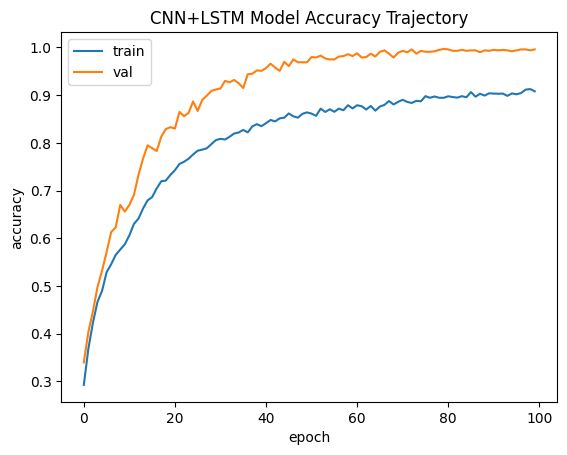

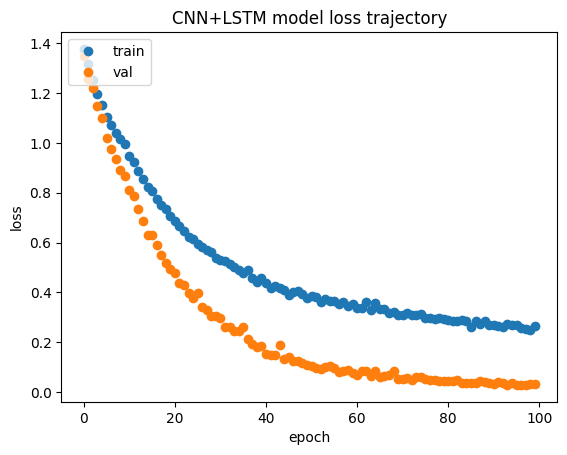

Test accuracy of CNN+LSTM model: 0.6659142374992371


0.6659142374992371

In [ ]:
evaluatemodel(lstmmodel, result, x_test, y_test)

## CNN + GRU

In [ ]:
# TESTING PARAMETERS
# kernel: 3,3 pool: 2,1, act: relu, dropout: 0.2 <- bad, relu, small dropout kernel and pool cause overfitting
# DROPOUT: 0.7 <- too high
filters_list = [25, 50, 100]
kernel_size = (8,8)
pool_size = (3,1)
activation = 'elu'
dropout_rate = 0.5
recurrent_dropout = 0.1
learning_rate = 1e-3
epochs = 100
batch_size = 64

#Load data
x_train, x_valid, x_test, y_train, y_valid, y_test = loadrnndata()

# Test the model with different hyperparameters
grumodel = grumodel(filters_list, kernel_size, pool_size, activation, dropout_rate, recurrent_dropout = recurrent_dropout)

result = trainmodel(grumodel, x_train, y_train, x_valid, y_valid, learning_rate = 1e-3, epochs = 100, batch_size = 64,  weightsname = 'gruall.h5')

Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set after dimension reshaping: (7460, 400, 1, 22)
Shape of validation set after dimension reshaping: (1000, 400, 1, 22)
Shape of test set after dimension reshaping: (443, 400, 1, 22)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 1, 25)        35225     
                                                                 
 max_pooling2d (MaxPooling2  (None, 134, 1, 25)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 134, 1, 25)        100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 134, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 134, 1, 50)        80050     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 1, 50)         0

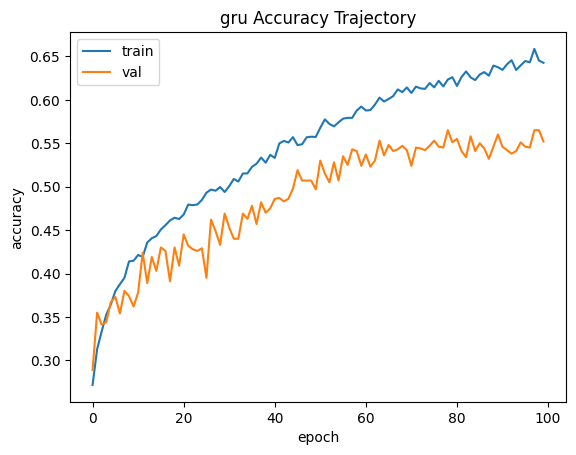

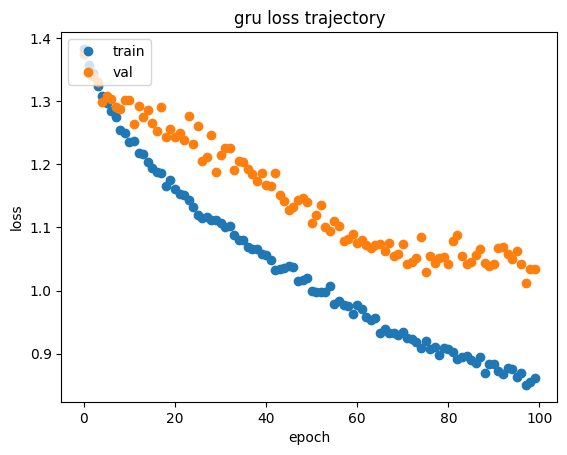

Test accuracy of gru model: 0.6094807982444763


0.6094807982444763

In [ ]:
evaluatemodel(grumodel, result, x_test, y_test, modeltype = 'gru')